<a href="https://colab.research.google.com/github/phong-utm/man2153-group-project/blob/master/walmart_sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Walmart Sales Forecasting

**Machine Learning (MANB2153) project by Desmon Chong Chee Fei and Nguyen Nam Phong**

# 0. Environment Settings

Importing data files and code from the accompanying GitHub repository:

In [ ]:
!rm -rf man2153-group-project
!git clone https://github.com/phong-utm/man2153-group-project.git

Cloning into 'man2153-group-project'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 52 (delta 23), reused 41 (delta 12), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [ ]:
# make our custom packages in GitHub code available for use in Colab
import sys
sys.path.append('/content/man2153-group-project/lib') # for Google Colab

# sys.path.append('man2153-group-project/lib') # for local notebook

from wsf_plot import *
from wsf_utils import *
from wsf_ann import *
from wsf_files import *

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = 'man2153-group-project/data'

# 1. Data Preparation

## 1.1. Importing input data files

There are 3 files to be imported:

###stores.csv

This file contains anonymized information about the 45 stores, indicating the type and size of store:

In [ ]:
df_stores = pd.read_csv(DATA_DIR + '/stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


###features.csv

This file contains additional data related to the store for the given dates:

In [ ]:
df_features = pd.read_csv(DATA_DIR + '/features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


###train.csv

This file contains weekly sales figures for each store and department:

In [ ]:
df_train = pd.read_csv(DATA_DIR + '/train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 1.2. Merging the data files

In [ ]:
# "stores" and "features" are merged on Store
df_store_features = df_stores.merge(df_features, on='Store')

# merge with "train" on the combination of Store and Date
df_merged = df_store_features.merge(
    df_train.drop(['IsHoliday'], axis=1), # drop colum appearing in 2 files
    on=['Store', 'Date']
)

df_merged.head()

# df_stores.shape, df_features.shape, df_store_features.shape, df_train.shape, df_merged.shape

,Store,Type,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales
0,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,1,24924.50
1,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,2,50605.27
2,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,3,13740.12
3,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,4,39954.04
4,1,A,151315,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,5,32229.38


## 1.3. Handling missing data

In [ ]:
df_merged.isnull().any()

Store           False
Type            False
Size            False
Date            False
Temperature     False
Fuel_Price      False
MarkDown1        True
MarkDown2        True
MarkDown3        True
MarkDown4        True
MarkDown5        True
CPI             False
Unemployment    False
IsHoliday       False
Dept            False
Weekly_Sales    False
dtype: bool

The statement above shows that only MarkDown1-5 contains *null* values which we can simply fill with zero:

In [ ]:
df_filled = df_merged.fillna(0)

## 1.4. Exploratory Data Analysis (EDA)

### 1.4.1. Correlation matrix

We create a matrix to find out which features have the highest/lowest correlation with weekly sales: 

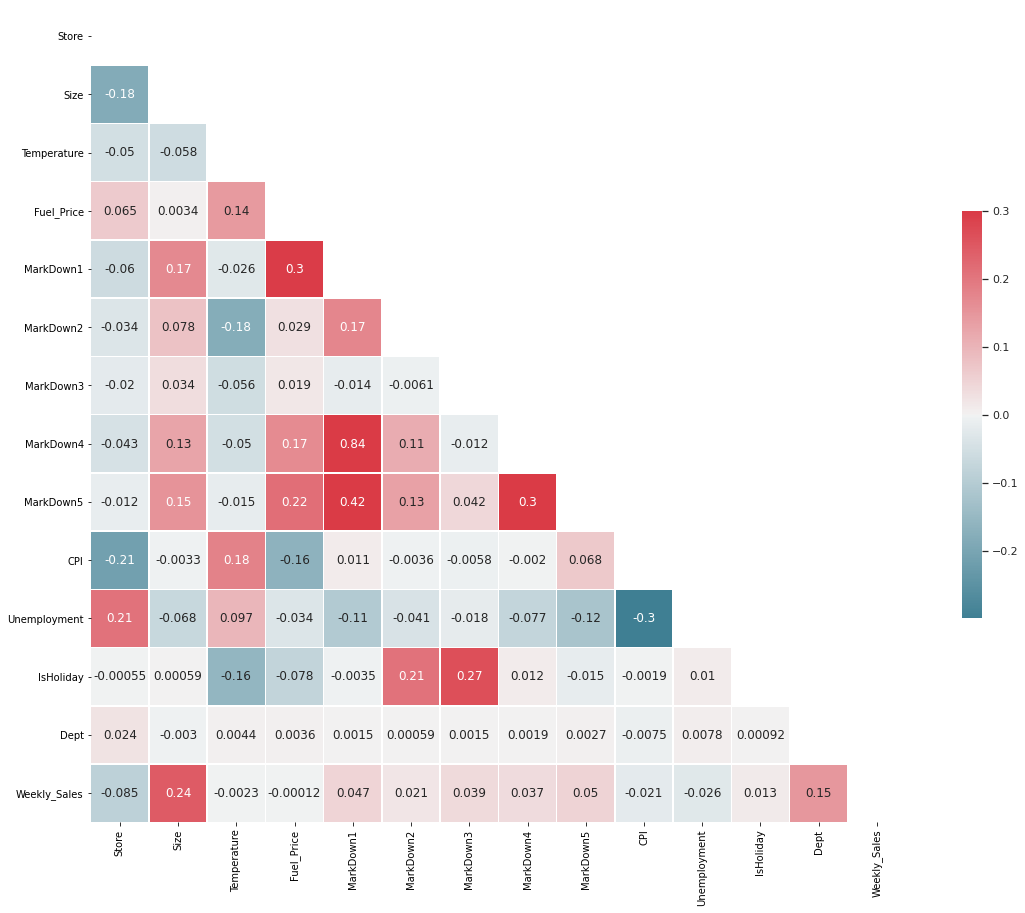

In [ ]:
wsf_plot_corr_matrix(df_filled.corr())

The matrix shows that *Store Size* has the highest correlation with weekly sales. Conversely, *Fuel Price* and *Temperature* have very low correlation and thus could potentially be removed from prediction.

### 1.4.2. Store size and Store type

We have found out that *Store Size* has the highest correlation with weekly sales. But does *Store Size* relate to *Store Type*, and if so, should we remove *Store Type* from our prediction?

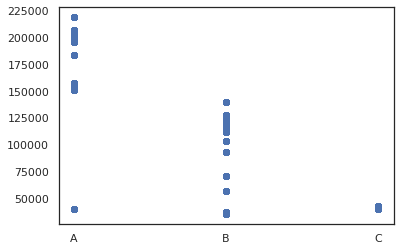

In [ ]:
plt.scatter('Type', 'Size', data=df_filled)
plt.show()

The scatter plot shows that type A is usually the largest, followed by type B, while C is the smallest. However, there seems to be some overlapping between them so we will keep *Store Type* for our prediction.

### 1.4.3. Negative weekly sales

When taking a closer look at weekly sales, we found that there are weeks registering negative sales (notice _min_ value below):

In [ ]:
df_filled['Weekly_Sales'].describe()

count    421570.000000
mean      15981.258123
std       22711.183519
min       -4988.940000
25%        2079.650000
50%        7612.030000
75%       20205.852500
max      693099.360000
Name: Weekly_Sales, dtype: float64

One possibility that might be able to explain negative sales is too much markdown. We need to check if that is the case here. (Note: another possibility is product returns but we have no data to verify it.)

In [ ]:
df_neg_sales = wsf_get_neg_sales(df_filled)
wsf_plot_violin(df_neg_sales, "No_MarkDown", "Weekly_Sales")

In the diagram above, large negative sales can be seen even when there was no markdown. With that, we should treat negative sales as outliers to be removed from prediction.

## 1.5. Removing outliners

As explained in the EDA, we should remove records with negative sales from our dataset:

In [ ]:
df_cleaned = df_filled[df_filled['Weekly_Sales'] > 0]

## 1.6. Handling non-numerical columns

There are some columns that we need to convert into numbers before we can use them as prediction input. These columns are *Type* (store type), *IsHoliday*, and *Date*:

In [ ]:
# convert "object" to "datetime"
serie_date = pd.to_datetime(df_cleaned['Date'])

# transform non-numerical columns
df_processed = pd.DataFrame({
  # A > B > C in size (see EDA section 1.4.2)
  'Type': df_cleaned['Type'].map({ 'A': 3, 'B': 2, 'C': 1 }),
  'IsHoliday': df_cleaned['IsHoliday'].map({ False: 0, True: 1 }),
  'Year': serie_date.dt.year,
  'Month': serie_date.dt.month,
  'Day': serie_date.dt.day
})

# merge with the other columns
df_processed = pd.concat([df_processed, df_cleaned.drop(columns=['Type', 'IsHoliday', 'Date'])], axis=1)

df_processed.head()

,Type,IsHoliday,Year,Month,Day,Store,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Dept,Weekly_Sales
0,3,0,2010,2,5,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,1,24924.50
1,3,0,2010,2,5,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,2,50605.27
2,3,0,2010,2,5,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,3,13740.12
3,3,0,2010,2,5,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,4,39954.04
4,3,0,2010,2,5,1,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,5,32229.38


## 1.7. Splitting train and test data

We put aside 20% of the data for validating and comparing the performance of the models that we will develop later:

In [ ]:
from sklearn.model_selection import train_test_split

X = df_processed.drop(columns='Weekly_Sales')
y = df_processed['Weekly_Sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Let's save the training and testing datasets into files so we have the freedom to train/re-train different models at any time while using the same datasets for all:

In [ ]:
wsf_save_train_dataset(X_train, y_train)
wsf_save_test_dataset(X_test, y_test)

# 2. Linear Regression Models

## 2.1. Lasso

Below we use Scikit-learn's *RandomizedSearchCV* to build several models using random combinations of parameters, then train and evaluate these models to identify the best one. 

In [ ]:
from sklearn.linear_model import Lasso

X_train, y_train = wsf_load_train_dataset()

lasso_params = {
  # constant that multiplies the L1 term
  'alpha': [np.float_power(10, x) for x in np.arange(-5, 5)]
}

df_lasso_train_results, lasso_best_model = wsf_find_best_model_cv(
  Lasso(), 
  lasso_params,
  X_train,
  y_train
)

df_lasso_train_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.092897,0.060845,0.019207,0.003418,0.001,{'alpha': 0.001},0.088437,0.086796,0.087704,0.087646,0.000671,2
1,0.665133,0.018157,0.019421,0.004175,1000,{'alpha': 1000.0},0.086720,0.085518,0.086158,0.086132,0.000491,4
2,1.666984,0.088325,0.017287,0.000597,0.1,{'alpha': 0.1},0.088437,0.086796,0.087704,0.087646,0.000671,3
3,0.507535,0.002278,0.017394,0.000714,10000,{'alpha': 10000.0},0.084186,0.083435,0.083567,0.083729,0.000327,5
4,1.946334,0.439466,0.014119,0.003038,0.0001,{'alpha': 0.0001},0.088437,0.086796,0.087704,0.087646,0.000671,1


The following chart shows the R-squared scores that we achieved during the training processs:

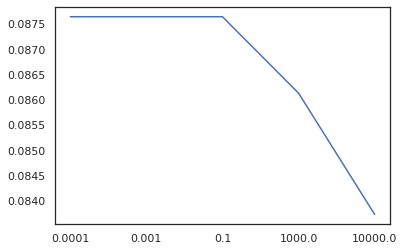

In [ ]:
wsf_plot_scores_by_param(df_lasso_train_results, 'param_alpha')

Here is the best parameter(s) that we have found:

In [ ]:
df_lasso_train_results[df_lasso_train_results['rank_test_score'] == 1]['params']

4    {'alpha': 0.0001}
Name: params, dtype: object

Save training results and the best model into files so we can compare with other models later:

In [ ]:
wsf_save_training_results(df_lasso_train_results, 'lasso')
wsf_save_best_model(lasso_best_model, 'lasso')

## 2.2. Ridge

Below we use Scikit-learn's *RandomizedSearchCV* to build several models using random combinations of parameters, then train and evaluate these models to identify the best one. 

In [ ]:
from sklearn.linear_model import Ridge

X_train, y_train = wsf_load_train_dataset()

ridge_params = {
  # constant that multiplies the L2 term
  'alpha': [np.float_power(10, x) for x in np.arange(-5, 5)],
  # solver to use in the computational routines
  'solver': ['auto', 'svd', 'cholesky', 'saga']
}

df_ridge_train_results, ridge_best_model = wsf_find_best_model_cv(
  Ridge(), 
  ridge_params,
  X_train,
  y_train
)

df_ridge_train_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.122776,0.011621,0.015736,0.002377,cholesky,1,"{'solver': 'cholesky', 'alpha': 1.0}",0.088437,0.086796,0.087704,0.087646,0.000671,2
1,0.103727,0.005618,0.013466,0.000379,auto,1,"{'solver': 'auto', 'alpha': 1.0}",0.088437,0.086796,0.087704,0.087646,0.000671,2
2,0.361645,0.036028,0.015169,0.001290,svd,10,"{'solver': 'svd', 'alpha': 10.0}",0.088437,0.086796,0.087704,0.087646,0.000671,1
3,0.109316,0.004593,0.017632,0.000668,auto,0.0001,"{'solver': 'auto', 'alpha': 0.0001}",0.088437,0.086796,0.087704,0.087646,0.000671,5
4,0.107262,0.013569,0.013360,0.002212,cholesky,0.001,"{'solver': 'cholesky', 'alpha': 0.001}",0.088437,0.086796,0.087704,0.087646,0.000671,4


The following chart shows the R-squared scores that we achieved during the training processs:

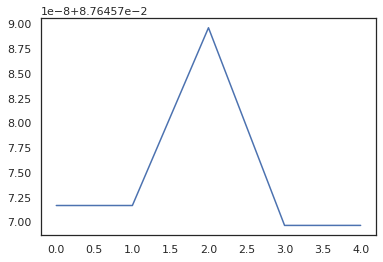

In [ ]:
wsf_plot_scores(df_ridge_train_results)

Here is the best parameter(s) that we have found:

In [ ]:
df_ridge_train_results[df_ridge_train_results['rank_test_score'] == 1]['params']

2    {'solver': 'svd', 'alpha': 10.0}
Name: params, dtype: object

Save training results and the best model into files so we can compare with other models later:

In [ ]:
wsf_save_training_results(df_ridge_train_results, 'ridge')
wsf_save_best_model(ridge_best_model, 'ridge')

# 3. Tree-based Models

## 3.1. Random Forest

Below we use Scikit-learn's *RandomizedSearchCV* to build several models using random combinations of parameters, then train and evaluate these models to identify the best one. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train, y_train = wsf_load_train_dataset()

rf_params = {
  # Number of trees in random forest
  'n_estimators': [2, 5, 10, 20, 40],
  # # Number of features to consider at every split
  # 'max_features': ['auto', 'sqrt', 'log2'],
  # # Maximum number of levels in tree
  # 'max_depth': [None, 10, 20, 30, 40, 50],
  # # Minimum number of samples required to split a node
  # 'min_samples_split': [2, 5, 10],
  # # Minimum number of samples required at each leaf node
  # 'min_samples_leaf': [1, 2, 4],
  # # Method of selecting samples for training each tree
  # 'bootstrap': [True, False]
}

df_rf_train_results, rf_best_model = wsf_find_best_model_cv(
  RandomForestRegressor(), 
  rf_params,
  X_train,
  y_train
)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [ ]:
df_rf_train_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.931169,0.065614,0.170449,0.005310,2,{'n_estimators': 2},0.948636,0.954531,0.951758,0.951642,0.002408,5
1,17.089968,0.047788,0.390219,0.003855,5,{'n_estimators': 5},0.963488,0.965578,0.962632,0.963899,0.001238,4
2,34.435433,0.034936,0.787704,0.022269,10,{'n_estimators': 10},0.968433,0.968112,0.966013,0.967519,0.001073,3
3,69.303561,0.241911,1.570657,0.052863,20,{'n_estimators': 20},0.969757,0.969538,0.966218,0.968505,0.001619,2
4,125.933733,14.578419,2.859194,0.257743,40,{'n_estimators': 40},0.971493,0.971589,0.968038,0.970374,0.001652,1


The following chart shows the R-squared scores that we achieved during the training processs:

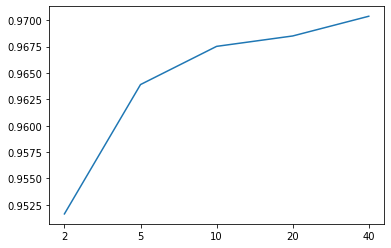

In [ ]:
wsf_plot_scores_by_param(df_rf_train_results, 'param_n_estimators')

Here is the best parameter(s) that we have found:

In [ ]:
df_rf_train_results[df_rf_train_results['rank_test_score'] == 1]['params']

4    {'n_estimators': 40}
Name: params, dtype: object

Save training results and the best model into files so we can compare with other models later:

In [ ]:
wsf_save_training_results(df_rf_train_results, 'rf')
wsf_save_best_model(rf_best_model, 'rf')

## 3.2. eXtreme Gradient Boosting (XGBoost)

Below we use Scikit-learn's *RandomizedSearchCV* to build several models using random combinations of parameters, then train and evaluate these models to identify the best one. 

In [ ]:
from xgboost import XGBRegressor

X_train, y_train = wsf_load_train_dataset()

xgb_params = {
  # Number of gradient boosted trees (number of boosting rounds)
  'n_estimators': [50, 100, 200, 500, 800],
  # # Maximum tree depth for base learners
  # 'max_depth': [None, 10, 20, 30, 40, 50],
  # # Boosting learning rate (xgb’s “eta”)
  # 'learning_rate': [0.001, 0.01, 0.1, 1, 10],
  # # Specify which booster to use 
  # 'booster': ['gbtree', 'gblinear', 'dart'],
  # # Specify which tree method to use
  # 'tree_method': ['auto', None, 'gpu_hist'],
  # # Minimum loss reduction required to make a further partition on a leaf node of the tree
  # 'gamma': [None, 0.001, 0.01, 0.1, 1, 10],
  # # Minimum sum of instance weight(hessian) needed in a child
  # 'min_child_weight': [None, 0.001, 0.01, 0.1, 1, 10],
  # # Maximum delta step we allow each tree’s weight estimation to be
  # 'max_delta_step': [None, 0.001, 0.01, 0.1, 1, 10],
  # # Subsample ratio of the training instance
  # 'subsample': [None, 0.1, 0.2, 0.3, 0.4],
  # # Subsample ratio of columns when constructing each tree
  # 'colsample_bytree': [None, 0.1, 0.2, 0.3, 0.4],
  # # Subsample ratio of columns for each level
  # 'colsample_bylevel': [None, 0.1, 0.2, 0.3, 0.4],
  # # Subsample ratio of columns for each split
  # 'colsample_bynode': [None, 0.1, 0.2, 0.3, 0.4],
  # # L1 regularization term on weights
  # 'reg_alpha': [None, 0.001, 0.01, 0.1, 1, 10],
  # # L2 regularization term on weights
  # 'reg_lambda': [None, 0.001, 0.01, 0.1, 1, 10]
}

df_xgb_train_results, xgb_best_model = wsf_find_best_model_cv(
  XGBRegressor(objective='reg:squarederror'), 
  xgb_params,
  X_train,
  y_train
)

In [ ]:
df_xgb_train_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,14.892265,0.077511,0.265927,0.002532,50,{'n_estimators': 50},0.655697,0.651813,0.645881,0.651130,0.004036,5
1,28.907863,0.335878,0.512264,0.008808,100,{'n_estimators': 100},0.746027,0.739154,0.737696,0.740959,0.003633,4
2,56.455156,0.650245,0.969518,0.008019,200,{'n_estimators': 200},0.804393,0.797824,0.797937,0.800051,0.003070,3
3,141.071644,2.096274,2.395776,0.021055,500,{'n_estimators': 500},0.851902,0.847206,0.844879,0.847996,0.002921,2
4,210.552821,24.250283,3.604641,0.467407,800,{'n_estimators': 800},0.870135,0.864786,0.864099,0.866340,0.002698,1


The following chart shows the R-squared scores that we achieved during the training processs:

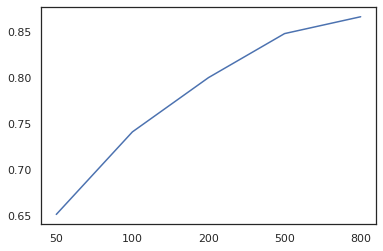

In [ ]:
wsf_plot_scores_by_param(df_xgb_train_results, 'param_n_estimators')

Here is the best parameter(s) that we have found:

In [ ]:
df_xgb_train_results[df_xgb_train_results['rank_test_score'] == 1]['params']

4    {'n_estimators': 800}
Name: params, dtype: object

Save training results and the best model into files so we can compare with other models later:

In [ ]:
wsf_save_training_results(df_xgb_train_results, 'xgb')
wsf_save_best_model(xgb_best_model, 'xgb')

# 4. Artificial Neural Networks (ANNs)

Unlike the other models, we can't use *RandomizedSearchCV* to build neural networks. Below we create several ANNs, train them with k-fold cross validatioin, and determine the best one. 

In [ ]:
%%capture

X_train, y_train = wsf_load_train_dataset()
ann_input_dim = X_train.shape[1]

# create several ANNs for experiments
neural_networks = [
  wsf_create_ann([(32, 'relu'), (64, 'relu')], ann_input_dim),
  wsf_create_ann([(32, 'relu'), (64, 'sigmoid')], ann_input_dim),
  wsf_create_ann([(64, 'relu'), (128, 'relu'), (64, 'relu')], ann_input_dim),
  wsf_create_ann([(64, 'relu'), (128, 'sigmoid'), (128, 'relu')], ann_input_dim),
  wsf_create_ann([(128, 'relu'), (128, 'relu'), (128, 'sigmoid')], ann_input_dim),
  # wsf_create_ann([(128, 'relu'), (256, 'relu')], ann_input_dim),
  # wsf_create_ann([(128, 'relu'), (256, 'sigmoid')], ann_input_dim),
  # wsf_create_ann([(256, 'relu'), (512, 'relu'), (256, 'relu')], ann_input_dim),
  # wsf_create_ann([(256, 'relu'), (512, 'sigmoid'), (512, 'relu')], ann_input_dim),
  # wsf_create_ann([(512, 'relu'), (512, 'relu'), (512, 'sigmoid')], ann_input_dim),
]

# train the ANNs using k-fold cross validation and identify the best one
df_ann_train_results, ann_best_index = wsf_find_best_ann_cv(neural_networks, X_train, y_train, epochs=100)

Below is a summary of the training results:

In [ ]:
df_ann_train_results

,split0_test_score,split1_test_score,split2_test_score,mean_test_score,mean_fit_time,model_id
0,0.198639,0.184094,0.206864,0.196532,52.878859,model-0
1,-0.456841,-0.462455,-0.465149,-0.461482,53.587907,model-1
2,0.295942,0.251427,0.259613,0.268994,99.689782,model-2
3,-0.000106,-0.000021,-0.000065,-0.000064,31.180454,model-3
4,-0.416061,-0.413292,-0.415157,-0.414837,156.248499,model-4


The following chart shows the R-squared scores that we achieved during the training processs:

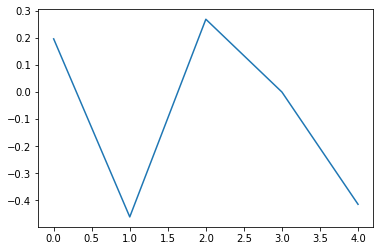

In [ ]:
wsf_plot_scores(df_ann_train_results)

Below is the ANN with the best score:

In [ ]:
ann_best_index

2

In [ ]:
%%capture
ann_best_model = neural_networks[ann_best_index]
wsf_train_ann(ann_best_model, X_train, y_train, epochs=200)

Save training results and the best model into files so we can compare with other models later:

In [ ]:
wsf_save_training_results(df_ann_train_results, 'ann')
wsf_save_best_ann(ann_best_model)

# 5. Model Comparison

We are going to compare the models in 3 aspects: the fit of the models, the Weighted Mean Absolute Error (WMAE), and model training time.

In [ ]:
train_results = {
  'Lasso': wsf_load_training_results('lasso'),
  'Ridge': wsf_load_training_results('ridge'),
  'Random Forest': wsf_load_training_results('rf'),
  'XGBoost': wsf_load_training_results('xgb'),
  'ANNs': wsf_load_training_results('ann'),
}

## 5.1. The fit of the models

The fit of a model is determined by its R-squared score. The following diagram shows the R-squared scores of the numerous models that we have created:

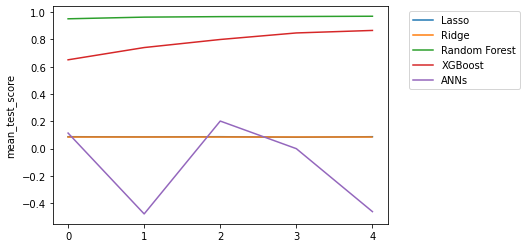

In [ ]:
wsf_plot_train_results(train_results, 'mean_test_score')

The diagram above shows that the tree-based models have the highest R-squared with Random Forest apparently at the top.

## 5.2. Weighted Mean Absolute Error (WMAE)

As mandated by Walmart, we need to calculate sales forecast errors for our best models using the WMAE metrics:

In [ ]:
lasso_best_model = wsf_load_best_model('lasso')
ridge_best_model = wsf_load_best_model('ridge')
rf_best_model = wsf_load_best_model('rf')
xgb_best_model = wsf_load_best_model('xgb')
ann_best_model = wsf_load_best_ann()

X_test, y_test = wsf_load_test_dataset()

prediction_errors = {
  'Lasso': wsf_predict_and_eval(lasso_best_model, X_test, y_test),
  'Ridge': wsf_predict_and_eval(ridge_best_model, X_test, y_test),
  'Random Forest': wsf_predict_and_eval(rf_best_model, X_test, y_test),
  'XGBoost': wsf_predict_and_eval(xgb_best_model, X_test, y_test),
  'ANNs': wsf_predict_and_eval(ann_best_model, X_test, y_test),
}

The following bar chart shows that *Random Forest* is also the best in terms of prediction error:

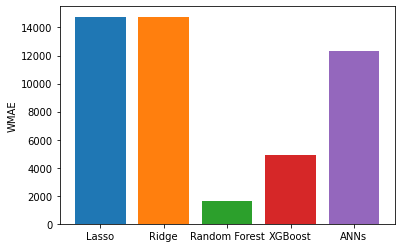

In [ ]:
wsf_plot_bar_chart(prediction_errors, 'WMAE')

## 5.3. Training time

The following chart shows how the models fare against one another in terms of training time:

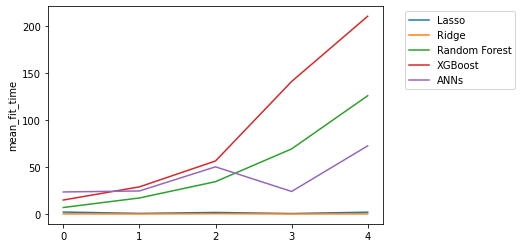

In [ ]:
wsf_plot_train_results(train_results, 'mean_fit_time')

# 6. Conclusions

Based on the results presented in the previous sections, we can draw a few conclusions as follows:

* Linear models such as Ridge and Lasso perform poorly in this particular problem, most probably because the relationship between the features and the output is complex and non-linear.

* The artificial neural networks show disappointing performance in forecasting sales. Hopefully they could produce better results if we had time for more extensive experiments.

* Tree-based models such as Random Forest and XGBoost posted the best prediction result with the highest R-squared and lowest errors. Random Forest tends to require less time for training while, at the same time, shows better prediction compared to XGBoost.

* Therefore, the best model we would propose to the client is Random Forest.